In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [38]:
class KMeansClustering(object):
    """Initializes `KMeansClustering` class instance.

    Attributes:
        num_points: int, number of input points to cluster.
        num_dims: int, number of dimensions of input points.
        num_clusters: int, number of clusters to assign points to.
        max_iterations: int, maximum number of iterations to attempt
            convergence before exiting loop.
        points: tensor, rank 2 tensor of shape (num_points, num_dims) that
            contains the coordinates of each point.
        points_expanded: tensor, rank 3 tensor of shape
            (1, num_points, num_dims) that enables broadcast subtraction of
            point coordinates with centroids.
        centroids: tf.Variable, rank 2 Variable of shape
            (num_clusters, num_dims) that contains the coordinates for each
            cluster centroid.
        assignments: tf.Variable, rank 1 Variable of shape (num_points,) that
            contains the cluster index assignment for each point.
        loss: tensor, rank 0 tensor of shape () that represents the current
            loss of the point assignment and centroid placement.
        old_loss: tensor, rank 0 tensor of shape () that represents the old
            loss of the point assignment and centroid placement.
    """
    def __init__(self, num_points, num_dims, num_clusters, max_iterations):
        """Initializes `KMeansClustering` class instance.

        Args:
            num_points: int, number of input points to cluster.
            num_dims: int, number of dimensions of input points.
            num_clusters: int, number of clusters to assign points to.
            max_iterations: int, maximum number of iterations to attempt
                convergence before exiting loop.
        """
        self.num_points = num_points
        self.num_dims = num_dims
        self.num_clusters = num_clusters
        self.max_iterations = max_iterations

        # Create random points.
        self.points = tf.constant(
            value=tf.random.uniform(
                shape=(self.num_points, self.num_dims), minval=0, maxval=10
            )
        )

        # Expand points to be able to do broadcast subtraction.
        self.points_expanded = tf.expand_dims(input=self.points, axis=0)

        # Initialize centroids at random point values.
        self.centroids = tf.Variable(
            initial_value=tf.slice(
                input_=tf.random.shuffle(value=self.points),
                begin=[0, 0],
                size=[self.num_clusters, -1]
            ),
            trainable=False
        )

        # Initialize assignments to first centroid.
        self.assignments = tf.Variable(
            initial_value=tf.zeros(
                shape=self.points.shape[0], dtype=tf.int64
            ),
            trainable=False
        )

        # Initialize losses.
        self.loss = tf.zeros(shape=[], dtype=tf.float32)
        self.old_loss = tf.ones(shape=[], dtype=tf.float32) * tf.float32.max

    @tf.function
    def assign_assignments(self, new_assignments):
        """Assigns new point centroid assignments to assignments variable.

        Args:
            new_assignments: tensor, rank 1 tensor of shape (batch_size,) that
                contains the centroid index assignments for each point.
        """
        self.assignments.assign(value=new_assignments)

    def find_closest_centroid_assignments(self):
        """Finds closest centroids for point assignments.
        """
        # Expand centroids to be able to do broadcast subtraction.
        self.centroids_expanded = tf.expand_dims(input=self.centroids, axis=1)

        # Calculate distances from points and centroids.
        distances = tf.math.reduce_sum(
            input_tensor=tf.square(
                x=self.points_expanded - self.centroids_expanded
            ),
            axis=2
        )

        # Assign points to closest centroid.
        self.assign_assignments(
            new_assignments=tf.math.argmin(input=distances, axis=0)
        )

        # Calculate loss using minimum euclidean distance.
        min_distances = tf.reduce_min(input_tensor=distances, axis=0)

        self.loss = tf.reduce_sum(input_tensor=min_distances)
        

    @tf.function
    def assign_centroids(self, new_centroids):
        """Assigns new centroid coordinates to centroids variable.

        Args:
            new_centroids: tensor, rank 2 tensor that contains the coordinates
                for each n-dimensional centroid.
        """
        self.centroids.assign(value=new_centroids)

    def compute_centroids(self):
        """Computes updated centroid coordinates.
        """
        means = []
        # Loop through all clusters.
        for cluster_idx in range(self.num_clusters):
            # Find indices for points assigned to this cluster.
            # shape = (num_points_assigned, 1)
            cluster_assignment_indices = tf.where(
                tf.equal(
                    x=self.assignments, y=cluster_idx
                )
            )

            # Gather assigned points to cluster.
            # shape = (1, num_points_assigned, num_dims)
            cluster_assigned_points = tf.gather(
                params=self.points,
                indices=tf.reshape(
                    tensor=cluster_assignment_indices,
                    shape=[1, -1]
                )
            )

            # Get cluster mean values for each dimension.
            # shape = (1, num_dims)
            cluster_mean = tf.math.reduce_mean(
                cluster_assigned_points,
                axis=1
            )

            # Append mean to list for concatenation after the loop.
            means.append(cluster_mean)

        self.assign_centroids(new_centroids=tf.concat(values=means, axis=0))

    def kmeans_clustering(self):
        """Performs kmeans clustering until convergence.
        """
        # Perform iterations until convergence.
        for iteration in range(self.max_iterations):
            # Find closest centroid assignments for points.
            self.find_closest_centroid_assignments()

            # Break early if system has converged.
            print("Iteration {} has {} loss.".format(iteration, self.loss))
            if self.loss >= self.old_loss:
                return
            self.compute_centroids()

            # Update loss.
            self.old_loss = self.loss

        # Perform final centroid assignment for points.
        self.find_closest_centroid_assignments()

            

In [39]:
kmeans = KMeansClustering(
    num_points=200, num_dims=2, num_clusters=3, max_iterations=100
)

In [40]:
kmeans.kmeans_clustering()

Iteration 0 has 1783.899658203125 loss.
Iteration 1 has 1342.667724609375 loss.
Iteration 2 has 1308.8055419921875 loss.
Iteration 3 has 1306.672607421875 loss.
Iteration 4 has 1305.2130126953125 loss.
Iteration 5 has 1305.2130126953125 loss.


In [41]:
kmeans.centroids

<tf.Variable 'Variable:0' shape=(3, 2) dtype=float32, numpy=
array([[6.283286 , 2.2797782],
       [7.019978 , 7.7304344],
       [1.398603 , 5.52407  ]], dtype=float32)>

In [42]:
kmeans.assignments

<tf.Variable 'Variable:0' shape=(200,) dtype=int64, numpy=
array([2, 1, 1, 0, 0, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1,
       2, 2, 0, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 0, 2, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 0, 0,
       2, 1, 0, 0, 0, 2, 2, 1, 2, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 2, 0,
       0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 1,
       0, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2,
       2, 1, 0, 0, 1, 1, 1, 0, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 1, 2, 1, 0,
       1, 2, 1, 0, 1, 2, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 0, 1, 2, 1, 0, 0,
       0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 1, 0, 2, 2, 0, 0,
       1, 2])>

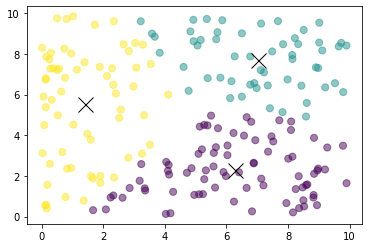

In [43]:
plt.scatter(
    x=kmeans.points[:, 0],
    y=kmeans.points[:, 1],
    c=kmeans.assignments.numpy(),
    s=50,
    alpha=0.5
)
plt.plot(
    kmeans.centroids[:, 0].numpy(),
    kmeans.centroids[:, 1].numpy(),
    "kx",
    markersize=15
)
plt.show()